In [1]:
from pycaret.regression import * 
import pandas as pd
import numpy as np

In [2]:
raw_data = pd.read_csv("train.csv")

In [3]:
need = ["상대 습도 (%)","섭씨 온도(°⁣C)","대기압(mbar)","공기 밀도 (g/m**3)","수증기 함량 (g/kg)","풍향 (deg)"]

In [4]:
all = need.copy()
all.append("풍속 (m/s)")

In [5]:
# SWAP 노이즈를 주기 위해 월별, 시간대로 데이터를 모음
dict_temp = {
    "오후" : [],
    "저녁" : [],
    "오전" : [],
    "새벽" : [],
}

humid_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["상대 습도 (%)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    humid_dict[i] = temp_

temp_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["섭씨 온도(°⁣C)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    temp_dict[i] = temp_

mbar_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["대기압(mbar)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    mbar_dict[i] = temp_

gm_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["공기 밀도 (g/m**3)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    gm_dict[i] = temp_

gkg_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["수증기 함량 (g/kg)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    gkg_dict[i] = temp_

deg_dict= {} 
for i in range(1,13):
    temp_ = dict_temp.copy()
    for j in temp_:
        temp_[j] = list(raw_data["풍향 (deg)"].where((raw_data["월"] == i) & (raw_data["측정 시간대"] == j)).dropna().values)
    deg_dict[i] = temp_
    

In [6]:
def make_noise(iter = 1):
    # Swap noise를 적용하는 함수를 수정하여 10% 확률로 swap합니다.
    def add_swap_noise(input_data, num_iterations=1000):
        data_mix = np.array(input_data)
        swap_probability = 0.3
        
        for _ in range(num_iterations):
            if np.random.random() <= swap_probability:
                while True:
                    idx1 = np.random.randint(0, data_mix.shape[0])
                    idx2 = np.random.randint(0, data_mix.shape[0])
                    if idx1 != idx2:
                        break
                data_mix[idx1], data_mix[idx2] = data_mix[idx2], data_mix[idx1]  # 값 교환
        return data_mix
    res_noisy_df = pd.DataFrame()
    for _ in range(iter):
        # Noisy 데이터를 DataFrame에 저장
        noisy_df = raw_data.copy()
        all_dicts = [humid_dict, temp_dict, mbar_dict, gm_dict, gkg_dict, deg_dict]

        for column, dictionary in zip(need, all_dicts):
            for month in range(1, 13):
                for time_of_day, row_indices in dict_temp.items():
                    mask = (noisy_df['월'] == month) & (noisy_df['측정 시간대'] == time_of_day)
                    original_data = raw_data.loc[mask, column].values
                    if len(original_data) > 0:
                        noisy_data = add_swap_noise(original_data)
                        noisy_df.loc[mask, column] = noisy_data

        res_noisy_df = pd.concat([res_noisy_df,noisy_df])

    return res_noisy_df.reset_index()

In [7]:
res_noisy_df = make_noise(3)

In [8]:
test_data = raw_data[all].sample(int(raw_data.shape[0]*0.2)).reset_index().drop("index",axis=1)

In [9]:
datas = res_noisy_df[all]

In [10]:
reg = setup(datas, test_data=test_data, target = '풍속 (m/s)',normalize=True,normalize_method="zscore",index=False)

,Description,Value
0,Session id,2081
1,Target,풍속 (m/s)
2,Target type,Regression
3,Original data shape,"(117059, 7)"
4,Transformed data shape,"(117059, 7)"
5,Transformed train set shape,"(109743, 7)"
6,Transformed test set shape,"(7316, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [11]:
compare_models(sort = 'MAE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:49:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.8365,1.4579,1.2074,0.3884,0.3691,0.7158,0.1070
dt,Decision Tree Regressor,0.8918,2.1330,1.4604,0.1052,0.4369,0.7032,0.1860
huber,Huber Regressor,1.0270,2.1421,1.4635,0.1016,0.4193,0.8107,0.0580
lr,Linear Regression,1.0632,2.0645,1.4368,0.1341,0.4298,0.9485,0.2150
ridge,Ridge Regression,1.0632,2.0645,1.4368,0.1341,0.4298,0.9485,0.0320
lar,Least Angle Regression,1.0632,2.0645,1.4368,0.1341,0.4298,0.9485,0.0360
br,Bayesian Ridge,1.0632,2.0645,1.4368,0.1341,0.4298,0.9485,0.0350
omp,Orthogonal Matching Pursuit,1.0985,2.2024,1.4840,0.0763,0.4428,0.9950,0.0320
lasso,Lasso Regression,1.1580,2.3844,1.5441,-0.0001,0.4654,1.0845,0.0330
en,Elastic Net,1.1580,2.3844,1.5441,-0.0001,0.4654,1.0845,0.0320


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
xgb = create_model("xgboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7446,1.0585,1.0288,0.5515,0.3252,0.6509
1,0.7433,1.0620,1.0306,0.5478,0.3288,0.6551
2,0.7622,1.0950,1.0464,0.5468,0.3318,0.6619
3,0.7619,1.1186,1.0576,0.5215,0.3320,0.6734
4,0.7483,1.0538,1.0266,0.5508,0.3235,0.6465
5,0.7400,1.0444,1.0219,0.5577,0.3208,0.6311
6,0.7655,1.1220,1.0593,0.5227,0.3328,0.6688
7,0.7498,1.0665,1.0327,0.5465,0.3254,0.6393
8,0.7697,1.1483,1.0716,0.5596,0.3282,0.6331


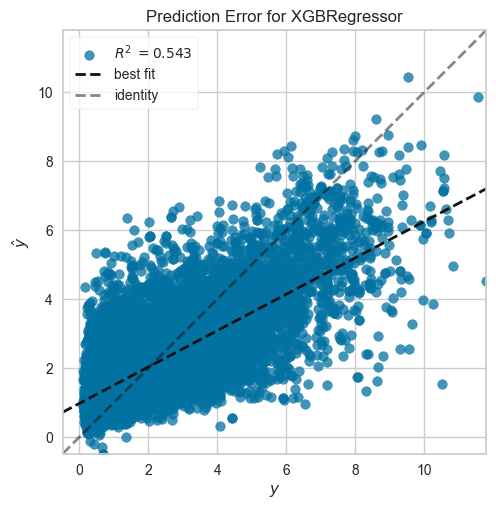

In [ ]:
plot_model(xgb,"error")

In [ ]:
save_model(best_model,"best_model")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/zj/ry181lrn51v4cznkcn0hmgzw0000gn/T/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['상대 습도 (%)', '섭씨 온도(°\u2063C)',
                                              '대기압(mbar)', '공기 밀도 (g/m**3)',
                                              '수증기 함량 (g/kg)', '풍향 (deg)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=RobustScaler())),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=7082))]),
 'best_model.pkl')